# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso,LinearRegression, Ridge 

from src.config import DADOS, PALETTE
from src.funcao import avaliar_modelo_r2, best_estimator, stepwise_selection



In [5]:
# Importando a base de dados
df = pd.read_csv(DADOS)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             15000 non-null  int64  
 1   data_ref               15000 non-null  object 
 2   id_cliente             15000 non-null  int64  
 3   sexo                   15000 non-null  object 
 4   posse_de_veiculo       15000 non-null  bool   
 5   posse_de_imovel        15000 non-null  bool   
 6   qtd_filhos             15000 non-null  int64  
 7   tipo_renda             15000 non-null  object 
 8   educacao               15000 non-null  object 
 9   estado_civil           15000 non-null  object 
 10  tipo_residencia        15000 non-null  object 
 11  idade                  15000 non-null  int64  
 12  tempo_emprego          12427 non-null  float64
 13  qt_pessoas_residencia  15000 non-null  float64
 14  renda                  15000 non-null  float64
dtypes:

In [7]:
df.head()

,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,0,2015-01-01,15056,F,False,True,0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34
1,1,2015-01-01,9968,M,True,True,0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15
2,2,2015-01-01,4312,F,True,True,0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89
3,3,2015-01-01,10639,F,False,True,1,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77
4,4,2015-01-01,7064,M,True,False,0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela
8. Avalie a previsão mediana do log(renda) nas bases de treinamento e teste. A previsão mediana do log(renda), por hipótese, é o mesmo que a previsão média do log(renda).
9. Obtenha a previsão mediana da renda - a mediana é o exponencial do item anterior. Observe que para a média não vale o mesmo resultado.
10. Divida a previsão do item 9 em 10 grupos. Calcule a média, mediana, percentil 5% e percentil 95% da renda para cada grupo. Faça um gráfico.
Analise e comente as limitações dessa previsão, e reflita sobre o quão útil é este modelo.









In [9]:
# Remover valores nulo
df.dropna(axis=0,inplace=True)




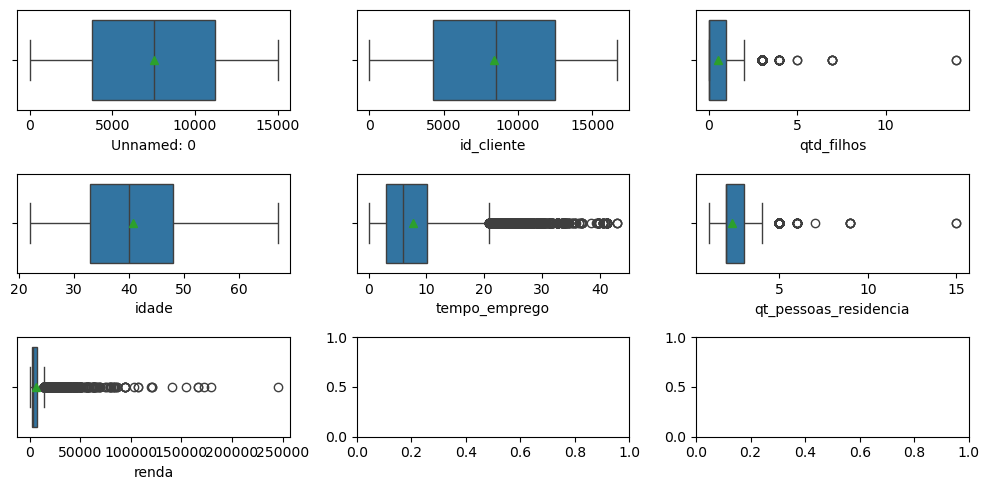

In [10]:
# identificação de outliers
fig, axs = plt.subplots(3, 3, figsize=(10, 5))

for ax, coluna in zip(axs.flatten(), df.select_dtypes("number").columns):
    sns.boxplot(data=df, x=coluna, ax=ax, showmeans=True)

plt.tight_layout()

plt.show()

In [11]:
# convertendo a coluna "qtd_filhos" em float
df["qtd_filhos"] = df["qtd_filhos"].astype(float)



In [12]:
QUANTIL = 0.99

df_clean = df[
    (df["qtd_filhos"] < df["qtd_filhos"].quantile(QUANTIL)) &
    (df["tempo_emprego"] < df["tempo_emprego"].quantile(QUANTIL)) &
    (df["qt_pessoas_residencia"] < df["qt_pessoas_residencia"].quantile(QUANTIL)) &
    (df["renda"] < df["renda"].quantile(QUANTIL))  # Corrigindo o nome da coluna
]



Calculando quanto dos nossos dados ainda permanecem depois da retirada do outiliers.


In [14]:

df_clean.shape[0]/ df.shape[0]

0.9645932244306752

In [15]:
# Removendo colunas desnecessárias
X = df_clean.drop(["Unnamed: 0", "data_ref","id_cliente", "renda"], axis=1)
y = df_clean["renda"]

In [16]:
# Transformando variáveis categórica em variáveis dummy
X = pd.get_dummies(X, drop_first=True)


In [17]:
y.info()

<class 'pandas.core.series.Series'>
Index: 11987 entries, 0 to 14999
Series name: renda
Non-Null Count  Dtype  
--------------  -----  
11987 non-null  float64
dtypes: float64(1)
memory usage: 187.3 KB


In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11987 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posse_de_veiculo               11987 non-null  bool   
 1   posse_de_imovel                11987 non-null  bool   
 2   qtd_filhos                     11987 non-null  float64
 3   idade                          11987 non-null  int64  
 4   tempo_emprego                  11987 non-null  float64
 5   qt_pessoas_residencia          11987 non-null  float64
 6   sexo_M                         11987 non-null  bool   
 7   tipo_renda_Bolsista            11987 non-null  bool   
 8   tipo_renda_Empresário          11987 non-null  bool   
 9   tipo_renda_Pensionista         11987 non-null  bool   
 10  tipo_renda_Servidor público    11987 non-null  bool   
 11  educacao_Pós graduação         11987 non-null  bool   
 12  educacao_Secundário            11987 non-null  bool

In [19]:
# Identifica colunas booleanas e as converte para int
X[X.select_dtypes(include=['bool']).columns] = X.select_dtypes(include=['bool']).astype(int)

In [20]:
# Separando em dados de treino (75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [21]:
# Lista de valores de alpha 
alphas = [0, 0.001, 0.005, 0.01, 0.05, 0.1]

In [22]:
# Testar Ridge
r2_ridge = avaliar_modelo_r2(alphas, X_train, y_train, X_test, y_test, mod_pre=Ridge, max_iter=600)
r2_ridge

[0.28664453746005414,
 0.286644540183983,
 0.2866445507889376,
 0.28664456339322575,
 0.28664463859746037,
 0.28664467063079646]

In [23]:
# Exibir resultados de R² para Ridge
print("R² para Ridge:")
for alpha, r2 in zip(alphas, r2_ridge):
   print(f'Alpha = {alpha}: R² = {r2}')

R² para Ridge:
Alpha = 0: R² = 0.28664453746005414
Alpha = 0.001: R² = 0.286644540183983
Alpha = 0.005: R² = 0.2866445507889376
Alpha = 0.01: R² = 0.28664456339322575
Alpha = 0.05: R² = 0.28664463859746037
Alpha = 0.1: R² = 0.28664467063079646


In [24]:
# Melhor estimador Ridge
best_estimator(alphas, r2_ridge)


(0.1, 0.28664467063079646)

In [25]:
# Testar Lasso
r2_lasso = avaliar_modelo_r2(alphas, X_train, y_train, X_test, y_test, mod_pre=Lasso, max_iter=1000)
r2_lasso

C:\Users\Gabriel\.ai-navigator\conda\envs\projeto_regressao\Lib\site-packages\sklearn\base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\Gabriel\.ai-navigator\conda\envs\projeto_regressao\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gabriel\.ai-navigator\conda\envs\projeto_regressao\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.157e+10, tolerance: 2.553e+07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one o

[0.2866442185789235,
 0.2866444146906798,
 0.28664518877266754,
 0.28664613305381925,
 0.2866527544496489,
 0.2866586990611145]

In [26]:
# Exibir resultados de R² para Lasso
print("\nR² para Lasso:")
for alpha, r2 in zip(alphas, r2_lasso):
   print(f'Alpha = {alpha}: R² = {r2}')


R² para Lasso:
Alpha = 0: R² = 0.2866442185789235
Alpha = 0.001: R² = 0.2866444146906798
Alpha = 0.005: R² = 0.28664518877266754
Alpha = 0.01: R² = 0.28664613305381925
Alpha = 0.05: R² = 0.2866527544496489
Alpha = 0.1: R² = 0.2866586990611145


In [27]:
# melhor estimador Lasso
best_estimator(alphas, r2_lasso)


(0.1, 0.2866586990611145)

In [28]:
# Verificar tipos das colunas
print(X_train.dtypes)

posse_de_veiculo                   int64
posse_de_imovel                    int64
qtd_filhos                       float64
idade                              int64
tempo_emprego                    float64
qt_pessoas_residencia            float64
sexo_M                             int64
tipo_renda_Bolsista                int64
tipo_renda_Empresário              int64
tipo_renda_Pensionista             int64
tipo_renda_Servidor público        int64
educacao_Pós graduação             int64
educacao_Secundário                int64
educacao_Superior completo         int64
educacao_Superior incompleto       int64
estado_civil_Separado              int64
estado_civil_Solteiro              int64
estado_civil_União                 int64
estado_civil_Viúvo                 int64
tipo_residencia_Casa               int64
tipo_residencia_Com os pais        int64
tipo_residencia_Comunitário        int64
tipo_residencia_Estúdio            int64
tipo_residencia_Governamental      int64
dtype: object


In [29]:


X_test[X_test.select_dtypes(include=['bool']).columns] = X_test.select_dtypes(include=['bool']).astype(int)


In [30]:
#stepwise
stepwise_selection(X,y)

Add  tempo_emprego                  with p-value 0.000000
Add  sexo_M                         with p-value 0.000000
Add  tipo_renda_Empresário          with p-value 0.000000
Add  educacao_Superior completo     with p-value 0.000000
Add  idade                          with p-value 0.000000
Add  qtd_filhos                     with p-value 0.000028
Add  posse_de_imovel                with p-value 0.000053
Add  tipo_renda_Servidor público    with p-value 0.000099

Melhor modelo Stepwise - R² na base de teste: 0.2924
Erro Quadrático Médio (MSE): 20419556.1307
Variáveis selecionadas: ['tempo_emprego', 'sexo_M', 'tipo_renda_Empresário', 'educacao_Superior completo', 'idade', 'qtd_filhos', 'posse_de_imovel', 'tipo_renda_Servidor público']


(['tempo_emprego',
  'sexo_M',
  'tipo_renda_Empresário',
  'educacao_Superior completo',
  'idade',
  'qtd_filhos',
  'posse_de_imovel',
  'tipo_renda_Servidor público'],
 LinearRegression(),
 np.float64(20419556.13069531),
 0.29239582072393044)

O $r^2$ do modelo stepwise é o maior até agora. Entretanto, ele não apresenta uma vantagem significativa, já que a diferença em relação a outros modelos, como ridge e lasso, não ultrapassa um ponto percentual. Talvez, com mais dados, ele possa apresentar um desempenho melhor.lhor.lhor.

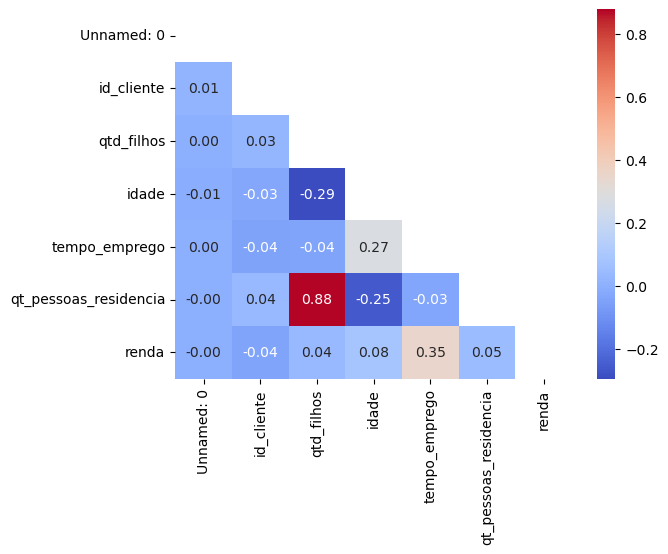

In [32]:
# mapa de correlação das colunas..
matriz = np.triu(df.select_dtypes("number").corr())

fig, ax = plt.subplots()

sns.heatmap(
    df_clean.select_dtypes("number").corr(),
    cmap=PALETTE,
    mask=matriz,
    annot=True,
    fmt=".2f",
    ax=ax
)

plt.show()

# Algumas variáveis novas: 
- categorizar tempo de emprego.
- quantidade de pessoas na residência por quantidade de filho.
- quandidade de pessoas na residência por idade.
- idade por tempo de emprego.

In [102]:
#categorizando a coluna tempo de emprego
df_clean.loc[:,"tempo_emprego_cat"] = pd.cut(df["tempo_emprego"],
                                bins=[0,3,7,float("inf")],
                                labels=["junior", "pleno","senior"]
                                )
df_clean["tempo_emprego_cat"]

0         pleno
1        senior
2        junior
3         pleno
4         pleno
          ...  
14994    senior
14995    senior
14997    senior
14998     pleno
14999    senior
Name: tempo_emprego_cat, Length: 11987, dtype: category
Categories (3, object): ['junior' < 'pleno' < 'senior']

In [35]:
df_clean["tempo_emprego_cat"].value_counts()

tempo_emprego_cat
senior    4970
pleno     3970
junior    3047
Name: count, dtype: int64

In [36]:
df_clean["qt_pessoa_res_por_idade"] = df["qt_pessoas_residencia"]/ df["idade"]
df_clean["indade_temp_emprego"]= df["idade"]/df["tempo_emprego"]

df_clean

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8200\2695813454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["qt_pessoa_res_por_idade"] = df["qt_pessoas_residencia"]/ df["idade"]
C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8200\2695813454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean["indade_temp_emprego"]= df["idade"]/df["tempo_emprego"]


,Unnamed: 0,data_ref,id_cliente,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,tempo_emprego_cat,qt_pessoa_res_por_idade,indade_temp_emprego
0,0,2015-01-01,15056,F,False,True,0.0,Empresário,Secundário,Solteiro,Casa,26,6.602740,1.0,8060.34,pleno,0.038462,3.937759
1,1,2015-01-01,9968,M,True,True,0.0,Assalariado,Superior completo,Casado,Casa,28,7.183562,2.0,1852.15,senior,0.071429,3.897788
2,2,2015-01-01,4312,F,True,True,0.0,Empresário,Superior completo,Casado,Casa,35,0.838356,2.0,2253.89,junior,0.057143,41.748366
3,3,2015-01-01,10639,F,False,True,1.0,Servidor público,Superior completo,Casado,Casa,30,4.846575,3.0,6600.77,pleno,0.100000,6.189938
4,4,2015-01-01,7064,M,True,False,0.0,Assalariado,Secundário,Solteiro,Governamental,33,4.293151,1.0,6475.97,pleno,0.030303,7.686662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,14994,2016-03-01,11477,M,True,False,0.0,Empresário,Superior incompleto,Casado,Casa,32,9.849315,2.0,1592.57,senior,0.062500,3.248957
14995,14995,2016-03-01,16006,F,False,True,0.0,Empresário,Secundário,Solteiro,Casa,48,13.887671,1.0,7990.58,senior,0.020833,3.456303
14997,14997,2016-03-01,6194,F,True,True,0.0,Assalariado,Superior completo,Casado,Casa,45,7.832877,2.0,604.82,senior,0.044444,5.745016
14998,14998,2016-03-01,4922,M,True,False,0.0,Empresário,Superior completo,Casado,Casa,36,4.298630,2.0,3352.27,pleno,0.055556,8.374761


### Reavaliando o melhor modelos a gora com novas colunas.



In [38]:
#separando a base targe e preditoras.
X = df_clean.drop(["renda",], axis=1)
y = df_clean["renda"]

In [39]:
# categorizando as preditoras.
X = pd.get_dummies(X)

In [40]:
# tranformando os dados booleanos em inteiros
X[X.select_dtypes(include=['bool']).columns] = X.select_dtypes(include=['bool']).astype(int)


In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11987 entries, 0 to 14999
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     11987 non-null  int64  
 1   id_cliente                     11987 non-null  int64  
 2   posse_de_veiculo               11987 non-null  int64  
 3   posse_de_imovel                11987 non-null  int64  
 4   qtd_filhos                     11987 non-null  float64
 5   idade                          11987 non-null  int64  
 6   tempo_emprego                  11987 non-null  float64
 7   qt_pessoas_residencia          11987 non-null  float64
 8   qt_pessoa_res_por_idade        11987 non-null  float64
 9   indade_temp_emprego            11987 non-null  float64
 10  data_ref_2015-01-01            11987 non-null  int64  
 11  data_ref_2015-02-01            11987 non-null  int64  
 12  data_ref_2015-03-01            11987 non-null  int6

In [42]:
# Separando em dados de treino (75%) e teste(25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [104]:
stepwise_selection(X,y)

Add  tempo_emprego                  with p-value 0.000000
Add  sexo_M                         with p-value 0.000000
Add  sexo_F                         with p-value 0.000000
Add  tipo_renda_Assalariado         with p-value 0.000000
Add  educacao_Superior completo     with p-value 0.000000
Add  idade                          with p-value 0.000000
Add  posse_de_imovel                with p-value 0.000022
Add  qtd_filhos                     with p-value 0.000101
Add  id_cliente                     with p-value 0.000132
Add  tempo_emprego_cat_senior       with p-value 0.000826
Add  data_ref_2016-03-01            with p-value 0.007970

Melhor modelo Stepwise - R² na base de teste: 0.2919
Erro Quadrático Médio (MSE): 20434454.8986
Variáveis selecionadas: ['tempo_emprego', 'sexo_M', 'sexo_F', 'tipo_renda_Assalariado', 'educacao_Superior completo', 'idade', 'posse_de_imovel', 'qtd_filhos', 'id_cliente', 'tempo_emprego_cat_senior', 'data_ref_2016-03-01']


(['tempo_emprego',
  'sexo_M',
  'sexo_F',
  'tipo_renda_Assalariado',
  'educacao_Superior completo',
  'idade',
  'posse_de_imovel',
  'qtd_filhos',
  'id_cliente',
  'tempo_emprego_cat_senior',
  'data_ref_2016-03-01'],
 LinearRegression(),
 np.float64(20434454.89856683),
 0.291879529853332)

Com a adição das novas colunas preditoras, o modelo teve um desempenho semelhante. No entanto, houve um aumento da complexidade do modelo. Por isso, vamos manter as colunas como estão para dar seguimento à nossa análise.